In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load results

In [2]:
def read_results(results_path):
    results_path = Path(results_path)

    return pd.concat({
        path.stem:
        pd.read_csv(path, index_col=0) for path in results_path.glob('*.csv')
    }, names=['Label', 'entry_name']).reset_index(level=0).groupby('Label').mean().reset_index()


In [3]:
results = pd.concat({
    'ArdiMiPE': read_results('/microbiome/kodrzywolek/publication/15-annotation-recovery/bac-iou/ardi-tape-uhgp_run_lmdb_1-avg/'),
    '3-mers': read_results('/microbiome/kodrzywolek/publication/15-annotation-recovery/bac-iou/3mers/'),
}, names=['Representation']).reset_index()
results

,Representation,level_1,Label,k=3,k=15,k=51,k=7,k=11,k=21,k=31,k=41,k=101
0,ArdiMiPE,0,EC number,0.894919,0.870029,0.822618,NaN,NaN,NaN,NaN,NaN,NaN
1,ArdiMiPE,1,Family,0.344456,0.260020,0.157931,NaN,NaN,NaN,NaN,NaN,NaN
2,ArdiMiPE,2,GO,0.875746,0.859859,0.818795,NaN,NaN,NaN,NaN,NaN,NaN
3,ArdiMiPE,3,Gene3D,0.935854,0.920780,0.885037,NaN,NaN,NaN,NaN,NaN,NaN
4,ArdiMiPE,4,Genus,0.211290,0.171783,0.118373,NaN,NaN,NaN,NaN,NaN,NaN
5,ArdiMiPE,5,InterPro,0.883926,0.864937,0.816772,NaN,NaN,NaN,NaN,NaN,NaN
6,ArdiMiPE,6,KO,0.900922,0.875769,0.827151,NaN,NaN,NaN,NaN,NaN,NaN
7,ArdiMiPE,7,Order,0.473167,0.395538,0.282183,NaN,NaN,NaN,NaN,NaN,NaN
8,ArdiMiPE,8,Pfam,0.895150,0.875084,0.828425,NaN,NaN,NaN,NaN,NaN,NaN
9,ArdiMiPE,9,Phylum,0.778383,0.738562,0.672998,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
classificators = results.filter(like='k=').columns.tolist()
classificators

['k=3', 'k=15', 'k=51', 'k=7', 'k=11', 'k=21', 'k=31', 'k=41', 'k=101']

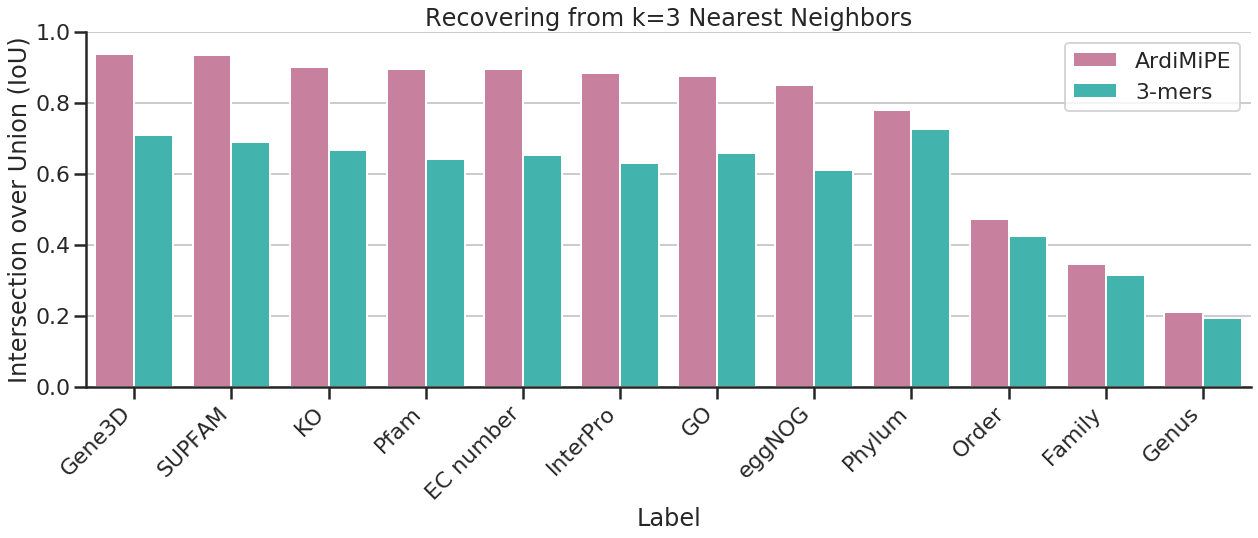

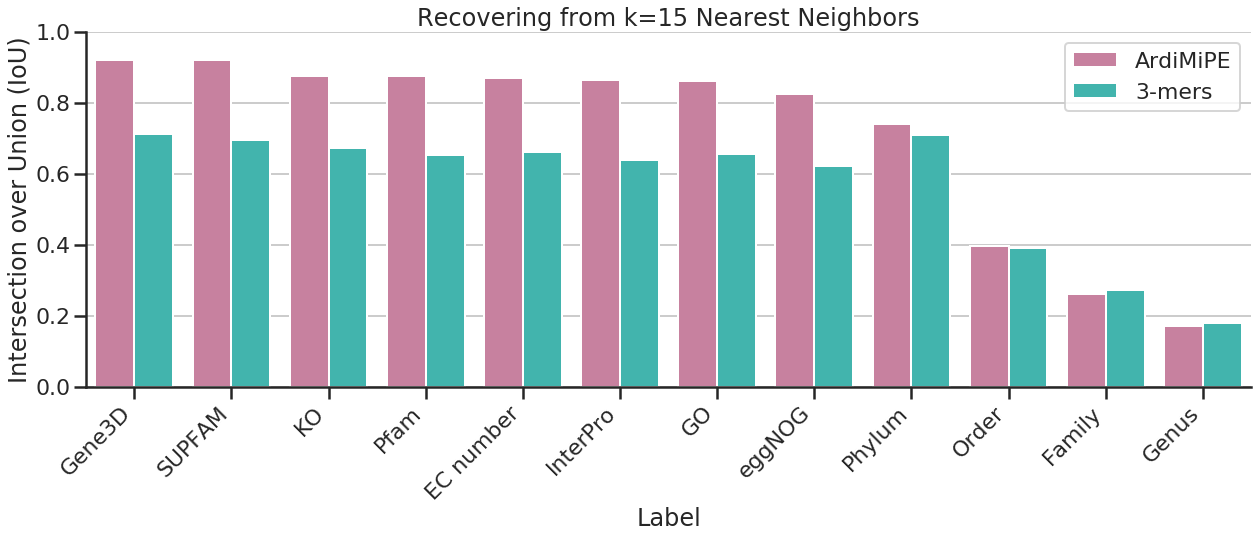

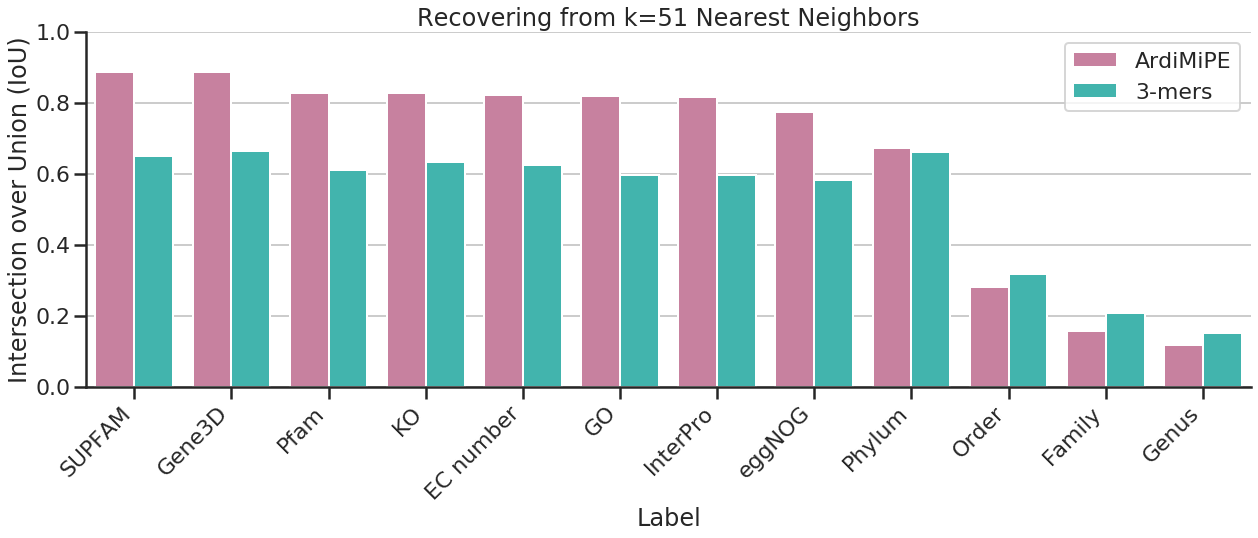

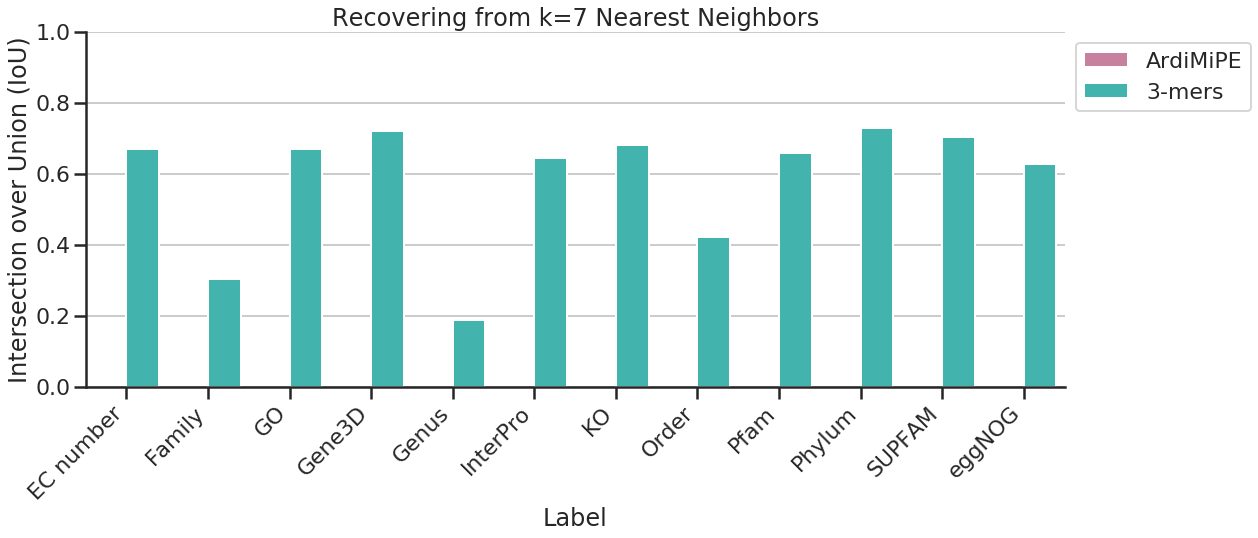

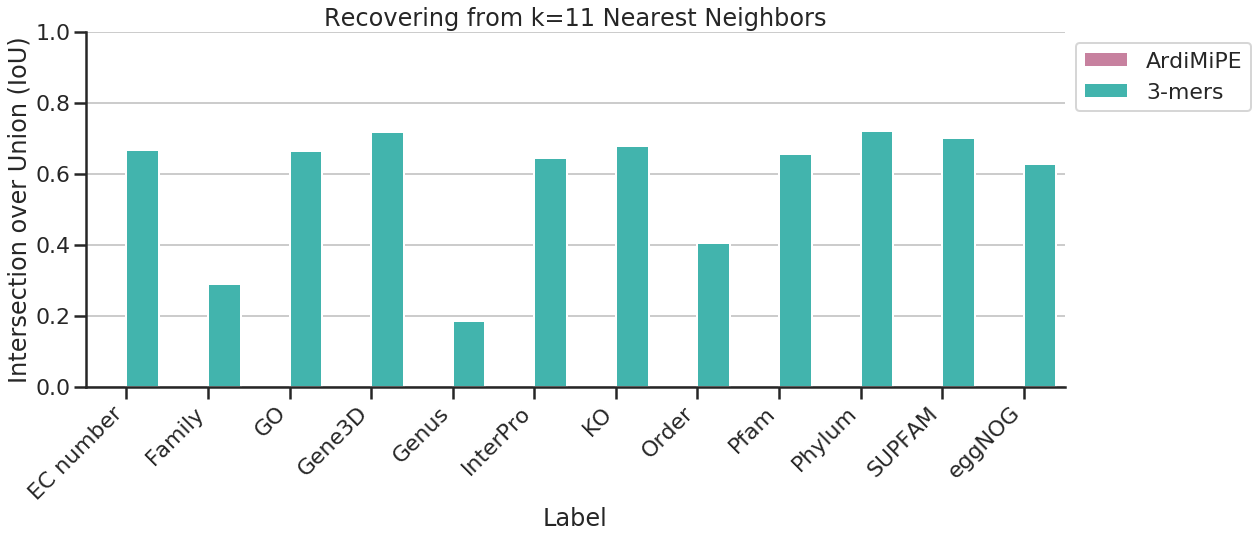

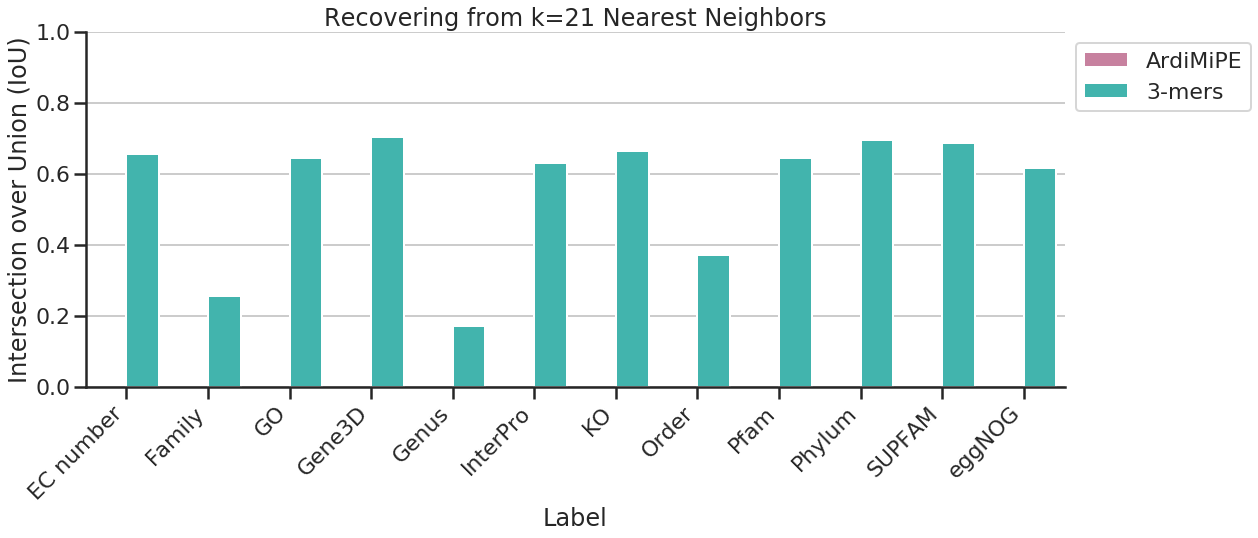

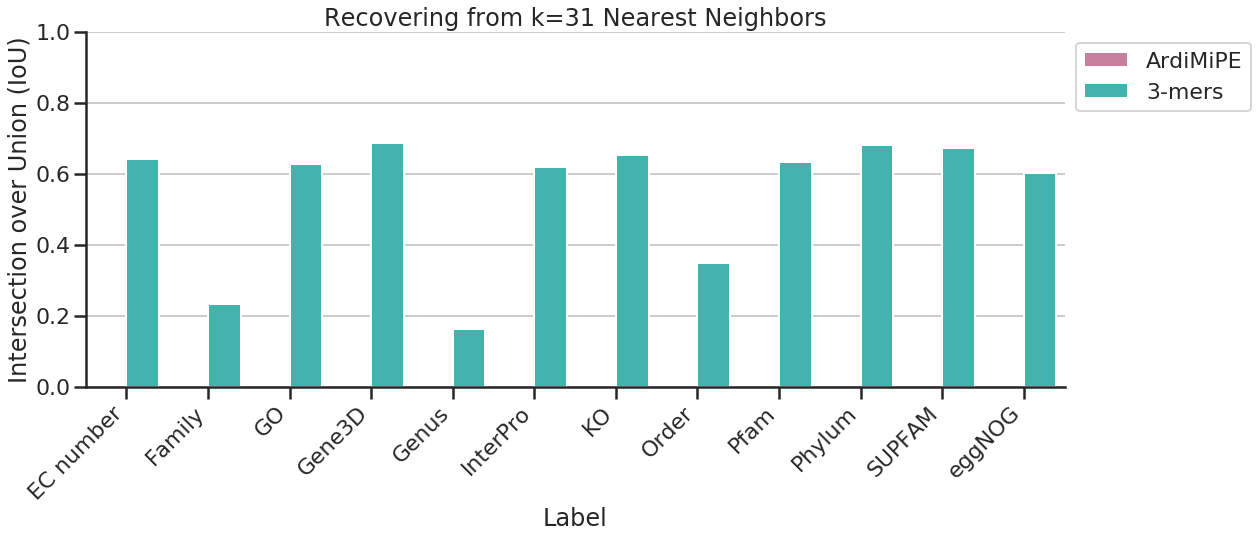

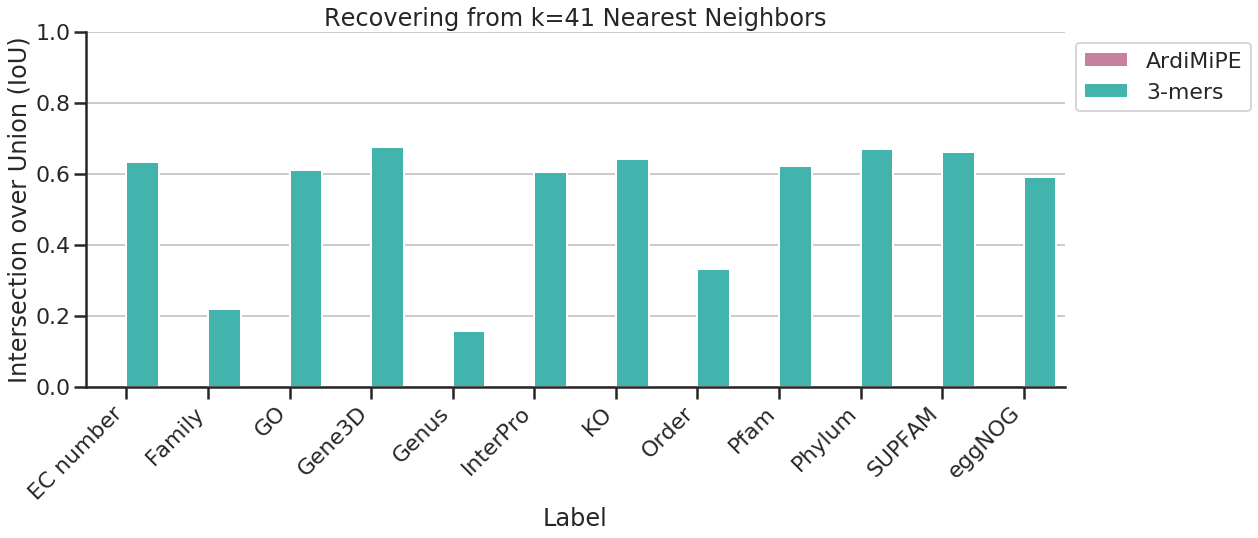

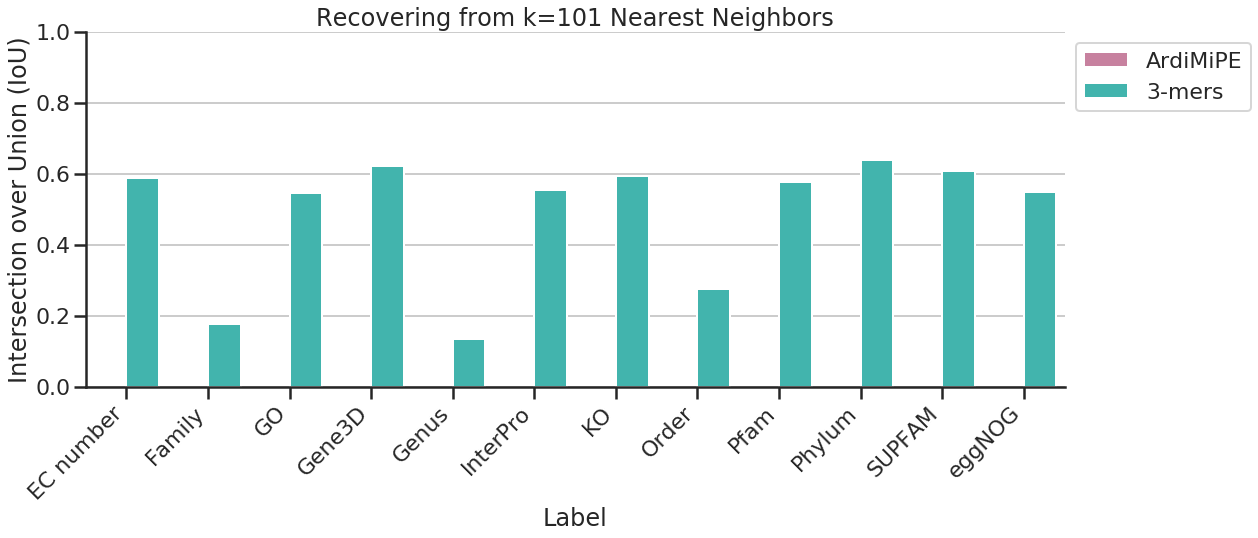

In [5]:
sns.set(context='poster', style='white')

for classificator in classificators:

    order = (
        results.query('Representation == "ArdiMiPE"')
            .groupby('Label')
            .mean()
            .sort_values(classificator, ascending=False).index
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(
        data=results,
        x='Label',
        y=classificator,
        hue='Representation',
        order=order,
        palette=["#d3759e", "#2fc7bd"],
    )
    
    
    plt.ylim(0,1)
    plt.ylabel('Intersection over Union (IoU)')
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.tick_left()
    plt.gca().xaxis.tick_bottom()
    
    sns.despine()
    plt.title(f'Recovering from {classificator} Nearest Neighbors')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()